# Introduction

This notebook presents **Vanilla RNN** applied to synthetic time-series data prediction problem (sine-wave)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Dataset

In [2]:
tsteps = np.linspace(0, 2*np.pi, 101)
sine = np.sin(tsteps)
cosine = np.cos(tsteps)
x_train_raw = sine[:-1]
y_train_raw = sine[1:]
x_valid_raw = cosine[:-1]
y_valid_raw = cosine[1:]

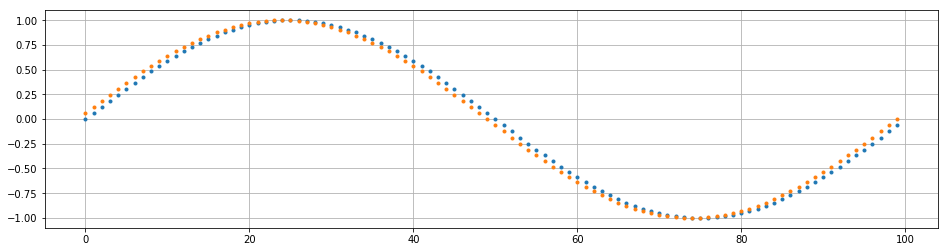

In [3]:
fig, ax = plt.subplots(figsize=[16,4])
ax.plot(x_train_raw, linestyle=' ', marker='.', label='input')
ax.plot(y_train_raw, linestyle=' ', marker='.', label='target')
ax.grid()
plt.show()

# Model

Define the model

In [4]:
class VanilaRNN(nn.Module):
    def __init__(self, n_hid, nb_layers=2):
        super(VanilaRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=n_hid,
                          num_layers=nb_layers, batch_first=True, bias=False)
        self.fc = nn.Linear(in_features=n_hid, out_features=1)
        # self.hidden_state = None  # keep hidden state between executions
    
    def forward(self, x, hid):                                 # shape [n_batch, n_seq, n_in]
        x, hid = self.rnn(x, hid)  # shape [n_batch, n_seq, n_hid]
        x = self.fc(x)                                         # dot product over last dim.
        return x, hid                                          # shape [n_batch, n_seq, n_out]
    
    def reset_hidden_state(self):
        self.hidden_state = None

Model hyperparameters

In [5]:
nb_layers = 2
n_batch = 1
n_seq = 10
n_in = 1
n_hid = 10
n_out = 1

Reshape data

In [6]:
x_train = torch.tensor(x_train_raw.reshape(n_batch, -1, n_in), dtype=torch.float32)
y_train = torch.tensor(y_train_raw.reshape(n_batch, -1, n_in), dtype=torch.float32)
x_valid = torch.tensor(x_valid_raw.reshape(n_batch, -1, n_in), dtype=torch.float32)
y_valid = torch.tensor(y_valid_raw.reshape(n_batch, -1, n_in), dtype=torch.float32)
x_train.shape

torch.Size([1, 100, 1])

Create model

In [7]:
model = VanilaRNN(n_hid=n_hid, nb_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
print(model)

VanilaRNN(
  (rnn): RNN(1, 10, bias=False, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


Sanity test model

In [8]:
xx = torch.randn([n_batch, n_seq, n_in])
with torch.no_grad():
    out, _ = model(xx, hid=None)
assert out.shape == (n_batch, n_seq, n_out)

Model performance before training

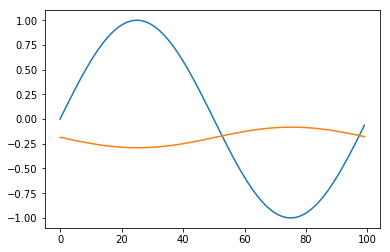

In [9]:
with torch.no_grad():
    output, _ = model(x_train, hid=None)
output_np = output.detach().numpy().flatten()
plt.plot(x_train.numpy().flatten())
plt.plot(output_np);

# Train Model

Train for 100 epochs

In [10]:
for e in range(100):
    hidden = None  # hidden state will be initialized automatically
    for i in range(0, x_train.shape[1], n_seq):
        
        # Slice out train data
        x = x_train[:,i:i+n_seq]
        y = y_train[:,i:i+n_seq]

        optimizer.zero_grad()

        output, hidden = model(x, hidden)
        hidden = hidden.detach()  # don't accumulate grad

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

Test model

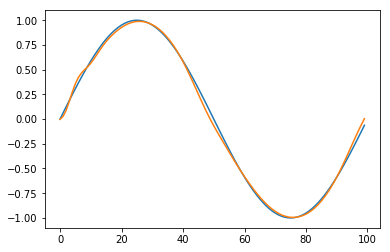

In [11]:
with torch.no_grad():
    output, _ = model(x_train, hid=None)
output_np = output.detach().numpy().flatten()
plt.plot(x_train.numpy().flatten())
plt.plot(output_np);

Test on cosine

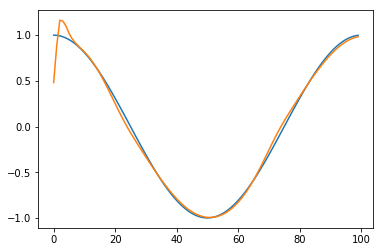

In [12]:
with torch.no_grad():
    output, _ = model(x_valid, hid=None)
output_np = output.detach().numpy().flatten()
plt.plot(x_valid.numpy().flatten())
plt.plot(output_np);